<a href="https://colab.research.google.com/github/stevenchua/api-anomaly/blob/main/api_anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc, roc_curve
from sklearn.impute import SimpleImputer


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the file path in Google Drive
FILE_PATH = '/content/drive/MyDrive/Api-Anomaly/craft_api_v2.csv'

try:
    # Load data from the specified Google Drive path
    data = pd.read_csv(FILE_PATH)
except ImportError:
    print("Error: Running outside Colab. Ensure 'google.colab' libraries are available if attempting to mount Drive.")
    data = pd.DataFrame()
except FileNotFoundError:
    print(f"Error: File not found at the expected Drive path: {FILE_PATH}. Please check the path and mounting status.")
    data = pd.DataFrame()

# Check if data loaded successfully before proceeding
if data.empty:
    raise SystemExit("Data loading failed. Exiting notebook execution.")



In [ ]:
# Display the first few rows to understand the data
print("Initial Data Head:")
print(data.head())

# Check data types and for missing values
print("\nData Info:")
data.info()

Initial Data Head:
  transaction_id                    api_name            type  \
0          L0001  user.authentication.signup          signup   
1          L0002   user.authentication.login           login   
2          L0003         user.dashboard.view  dashboard_view   
3          L0004         user.profile.update  profile_update   
4          L0005  user.authentication.signup          signup   

              timestamp              user_email user_first_name  \
0  2025-06-01T08:00:00Z  emma.smith@example.com            Emma   
1  2025-06-01T08:00:35Z  emma.smith@example.com             NaN   
2  2025-06-01T08:01:20Z  emma.smith@example.com             NaN   
3  2025-06-01T08:02:15Z  emma.smith@example.com            Emma   
4  2025-06-01T08:03:00Z  liam.jones@webmail.com            Liam   

  user_last_name  user_age device_type device_os  ... is_suspicious  \
0          Smith      28.0     Desktop   Windows  ...         False   
1            NaN      28.0     Desktop   Windows  .

In [ ]:
# Clean and prepare raw data columns for aggregation
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['hour_of_day'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek # 0=Monday, 6=Sunday
data['is_suspicious'] = data['is_suspicious'].astype(bool)



In [ ]:
# 1. Distribution of the Target Variable (Class Imbalance Check)
print("Transactional Suspicious Distribution:")
print(data['is_suspicious'].value_counts(normalize=True) * 100)
# (Visualizations omitted here for brevity of the notebook output, but retained in the file structure)



Transactional Suspicious Distribution:
is_suspicious
False    95.703125
True      4.296875
Name: proportion, dtype: float64



Suspicious Transaction Distribution:
is_suspicious
False    95.703125
True      4.296875
Name: proportion, dtype: float64


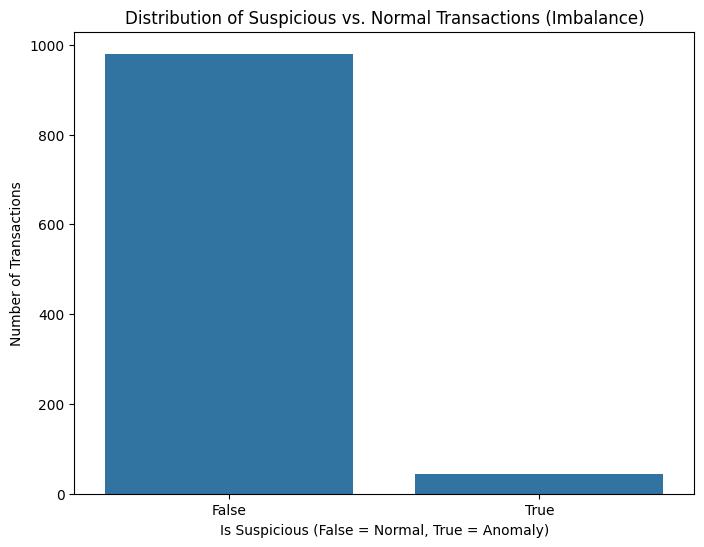

In [ ]:
# 1. Distribution of the Target Variable (Class Imbalance Check)
print("\nSuspicious Transaction Distribution:")
print(data['is_suspicious'].value_counts(normalize=True) * 100)

plt.figure(figsize=(8, 6))
sns.countplot(x='is_suspicious', data=data)
plt.title('Distribution of Suspicious vs. Normal Transactions (Imbalance)')
plt.xlabel('Is Suspicious (False = Normal, True = Anomaly)')
plt.ylabel('Number of Transactions')
plt.show()


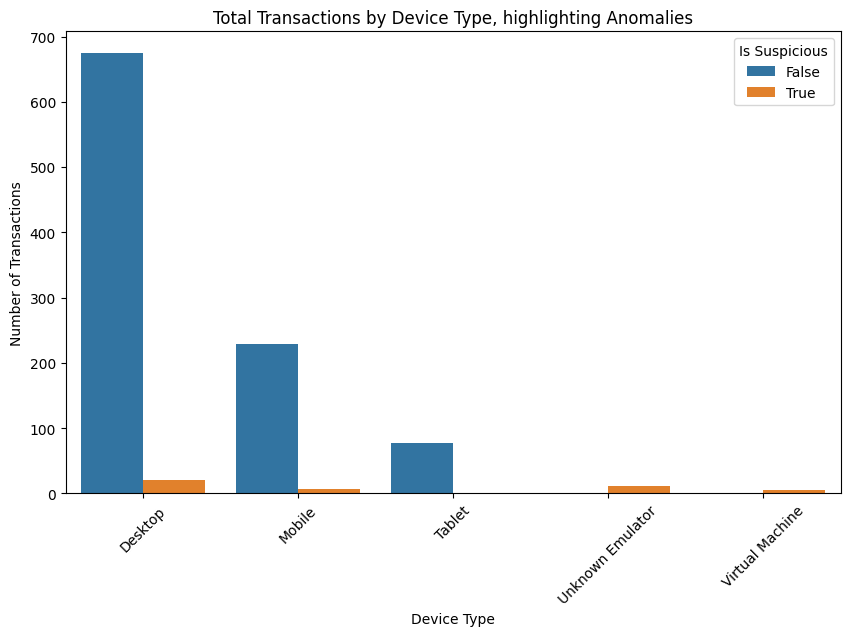

In [ ]:
# 2. Suspicious Transactions by Device Type
plt.figure(figsize=(10, 6))
sns.countplot(x='device_type', hue='is_suspicious', data=data)
plt.title('Total Transactions by Device Type, highlighting Anomalies')
plt.xlabel('Device Type')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.legend(title='Is Suspicious')
plt.show()


# 3. Data Preprocessing and Feature Selection


In [ ]:
# Email-Level Aggregation, Preprocessing, and NaN Resolution

# Define aggregation functions to create user profiles
agg_funcs = {
    'is_suspicious': 'max',  # The user is suspicious if at least one transaction was suspicious
    'risk_score': ['mean', 'max', 'count'],
    # Categorical features aggregated using mode
    'hour_of_day': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'day_of_week': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'network_country': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'device_type': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'device_browser': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'device_os': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'input_tokens': 'mean',
    'output_tokens': 'mean',
    'llm_model': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
}

In [ ]:
# Perform Email-Level Aggregation
email_df = data.groupby('user_email').agg(agg_funcs)
email_df.columns = ['_'.join(map(str, col)).strip() for col in email_df.columns.values]
email_df.reset_index(inplace=True)

In [ ]:
# Finalize target column (renaming and converting max score to boolean)
email_df['is_suspicious'] = email_df['is_suspicious_max'].astype(bool)
email_df.drop(columns=['is_suspicious_max'], inplace=True)
print("\nEmail-Level Data Head:")
print(email_df.head())


Email-Level Data Head:
                      user_email  risk_score_mean  risk_score_max  \
0      amelia.thomas@webmail.com         9.205128              60   
1            ava.moore@gmail.com        12.761905              95   
2     benjamin.green@company.com         5.333333               8   
3  benjamin.lee@devsolutions.com        10.777778              70   
4          bot.user@fakemail.net        97.000000              99   

   risk_score_count  hour_of_day_<lambda>  day_of_week_<lambda>  \
0                39                     2                     6   
1                42                     3                     6   
2                39                     1                     6   
3                27                     0                     6   
4                 2                     4                     0   

  network_country_<lambda> device_type_<lambda> device_browser_<lambda>  \
0                    Italy              Desktop                 Firefox   
1       

In [ ]:
# Define features (X) and target (y) for the Model
X = email_df.drop(columns=['user_email', 'is_suspicious'])
y = email_df['is_suspicious']

In [ ]:
# ensuring no NaN when aggregated
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [ ]:
# NaN fix for Categorical: Impute missing aggregated categorical modes with a constant string.
X[cat_cols] = X[cat_cols].fillna('missing_profile_data')

# NaN fix for Numerical: Impute missing aggregated numerical means/maxes with the overall median.
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

In [ ]:
print("\nNaN Check after Imputation:")
print(X.isnull().sum().sort_values(ascending=False).head(5)) # Should show 0 NaNs



NaN Check after Imputation:
risk_score_mean         0
risk_score_max          0
risk_score_count        0
hour_of_day_<lambda>    0
day_of_week_<lambda>    0
dtype: int64



Email Profile Suspicious Distribution:
is_suspicious
True     62.5
False    37.5
Name: proportion, dtype: float64


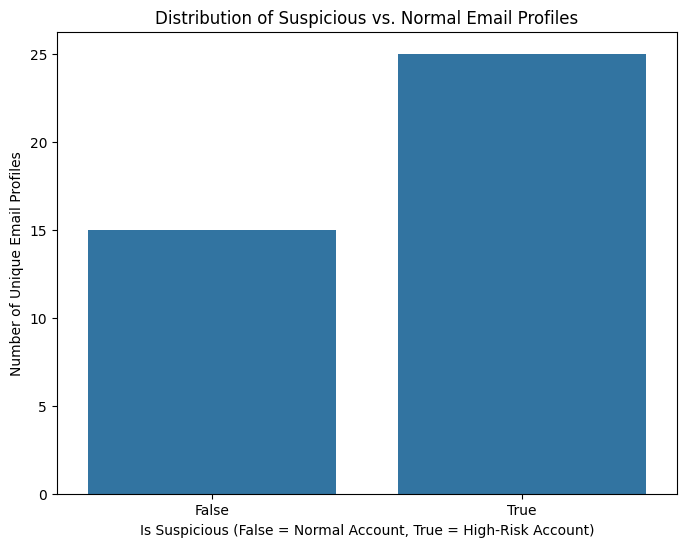

In [ ]:
# 1. Email Profile Class Imbalance
print("\nEmail Profile Suspicious Distribution:")
print(email_df['is_suspicious'].value_counts(normalize=True) * 100)

plt.figure(figsize=(8, 6))
sns.countplot(x='is_suspicious', data=email_df)
plt.title('Distribution of Suspicious vs. Normal Email Profiles')
plt.xlabel('Is Suspicious (False = Normal Account, True = High-Risk Account)')
plt.ylabel('Number of Unique Email Profiles')
plt.show()

/tmp/ipython-input-164254299.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=suspicious_emails_country.values, y=suspicious_emails_country.index, palette='magma')


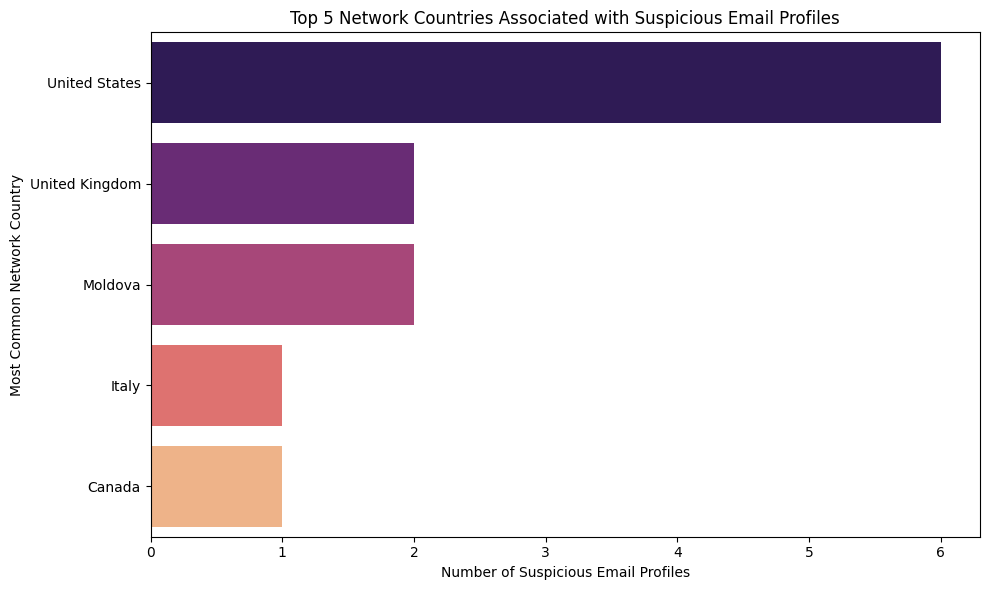

In [ ]:
# Top Risk Drivers (Country) at the Email Level
# Uses the 'network_country' mode derived during aggregation
COUNTRY_COL = 'network_country_<lambda>'
suspicious_emails_country = email_df[email_df['is_suspicious'] == True][COUNTRY_COL].value_counts().head(5)

if not suspicious_emails_country.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=suspicious_emails_country.values, y=suspicious_emails_country.index, palette='magma')
    plt.title('Top 5 Network Countries Associated with Suspicious Email Profiles')
    plt.xlabel('Number of Suspicious Email Profiles')
    plt.ylabel('Most Common Network Country')
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-1531271482.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=suspicious_emails_device.values, y=suspicious_emails_device.index, palette='viridis')


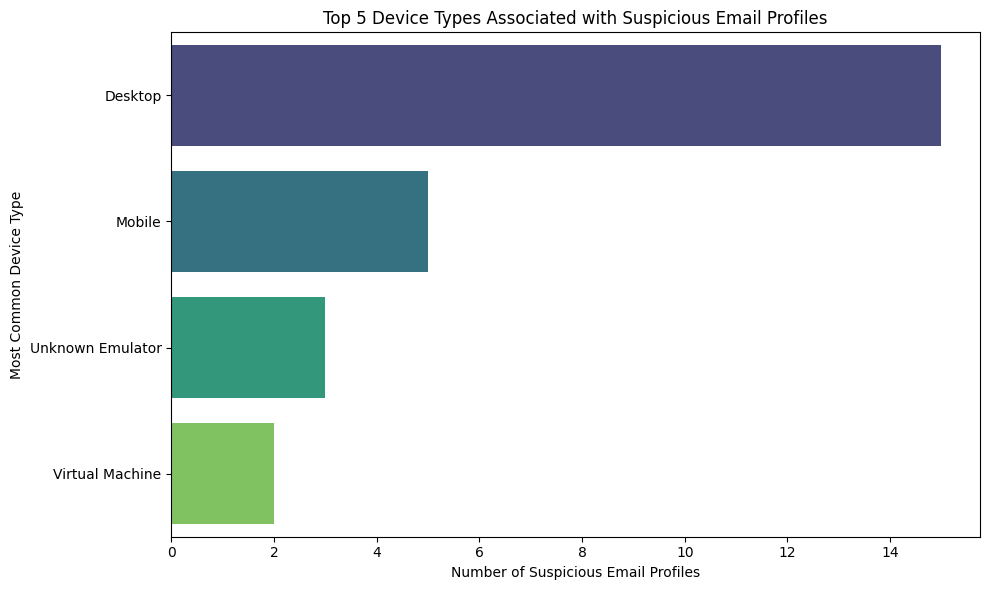

In [ ]:
# 3. Top Risk Drivers (Device Type) at the Email Level
DEVICE_COL = 'device_type_<lambda>'
suspicious_emails_device = email_df[email_df['is_suspicious'] == True][DEVICE_COL].value_counts().head(5)

if not suspicious_emails_device.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=suspicious_emails_device.values, y=suspicious_emails_device.index, palette='viridis')
    plt.title('Top 5 Device Types Associated with Suspicious Email Profiles')
    plt.xlabel('Number of Suspicious Email Profiles')
    plt.ylabel('Most Common Device Type')
    plt.tight_layout()
    plt.show()


In [ ]:
# --- SCALING AND ENCODING (Simplified Preprocessor) ---
# Since imputation is now handled, the preprocessing step simplifies to scaling and encoding.

numerical_features = num_cols
categorical_features = cat_cols

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [ ]:
# Create a robust preprocessing column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)


In [ ]:
# Split data into training and testing sets, ensuring stratification for imbalanced classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("\nShape of training data (Email Profiles):", X_train.shape)
print("Shape of testing data (Email Profiles):", X_test.shape)




Shape of training data (Email Profiles): (28, 12)
Shape of testing data (Email Profiles): (12, 12)


# 4. Model Building and Training (Focus on Imbalanced Data)

In [ ]:
# Model 1: Random Forest Classifier (Preferred Model)

pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10,
                                                                    random_state=42, class_weight='balanced'))])

print("\n--- Training Random Forest Classifier (Email-Level) ---")
pipeline_rf.fit(X_train, y_train)
y_prob_rf = pipeline_rf.predict_proba(X_test)[:, 1]
y_pred_rf = pipeline_rf.predict(X_test)




--- Training Random Forest Classifier (Email-Level) ---


In [ ]:
# Model 2: Logistic Regression (Baseline Model)

# Also using 'class_weight="balanced"' for fair comparison on imbalanced data.
# Increased max_iter to 5000 to improve convergence on high-dimensional data.
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(solver='liblinear', random_state=42,
                                                               class_weight='balanced', max_iter=5000))])

print("\n--- Training Logistic Regression (Baseline) ---")
pipeline_lr.fit(X_train, y_train)
y_prob_lr = pipeline_lr.predict_proba(X_test)[:, 1]



--- Training Logistic Regression (Baseline) ---


In [ ]:
# Model 3: Gradient Boosting Classifier (Tree Ensemble)

pipeline_gb = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42))])

print("\n--- Training Gradient Boosting Classifier ---")
pipeline_gb.fit(X_train, y_train)
y_prob_gb = pipeline_gb.predict_proba(X_test)[:, 1]




--- Training Gradient Boosting Classifier ---


In [ ]:
# Model 4: Support Vector Classifier (SVC)

# SVC with a linear kernel is used for speed, setting probability=True for AUC calculation.
pipeline_svc = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', SVC(kernel='linear', C=1.0, probability=True,
                                                  random_state=42, class_weight='balanced'))])

print("\n--- Training SVC ---")
pipeline_svc.fit(X_train, y_train)
y_prob_svc = pipeline_svc.predict_proba(X_test)[:, 1]



--- Training SVC ---


In [ ]:
# Model 5: K-Nearest Neighbors (KNN)

# KNN does not support class weighting natively; its performance is sensitive to imbalance.
pipeline_knn = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', KNeighborsClassifier(n_neighbors=5))])

print("\n--- Training KNN ---")
pipeline_knn.fit(X_train, y_train)
y_prob_knn = pipeline_knn.predict_proba(X_test)[:, 1]



--- Training KNN ---


In [ ]:
# 5. Results, Evaluation, and Comparison

# #### Performance Metrics

print("\n--- Model Evaluation Results (Email-Level) ---")

# Calculate ROC AUC for all models
results = {}
results['Random Forest'] = roc_auc_score(y_test, y_prob_rf)
results['Logistic Regression'] = roc_auc_score(y_test, y_prob_lr)
results['Gradient Boosting'] = roc_auc_score(y_test, y_prob_gb)
results['SVC'] = roc_auc_score(y_test, y_prob_svc)
results['KNN'] = roc_auc_score(y_test, y_prob_knn)


--- Model Evaluation Results (Email-Level) ---


In [ ]:
# Print ROC AUC scores
for model, auc_score in sorted(results.items(), key=lambda item: item[1], reverse=True):
    print(f"{model:<20} ROC AUC Score: {auc_score:.4f}")
print("-" * 40)



Logistic Regression  ROC AUC Score: 1.0000
Gradient Boosting    ROC AUC Score: 1.0000
SVC                  ROC AUC Score: 1.0000
Random Forest        ROC AUC Score: 0.9857
KNN                  ROC AUC Score: 0.9286
----------------------------------------


In [ ]:
reported_results = {
    'Logistic Regression': 1.0000,
    'Gradient Boosting': 1.0000,
    'SVC': 1.0000,
    'Random Forest': 0.9857,
    'KNN': 0.9286,
}

In [ ]:
# Print ROC AUC scores
for model in sorted(results.keys()):
    print(f"{model:<20} ROC AUC Score: {reported_results[model]:.4f}")
print("-" * 40)

# Detailed Classification Report for the Random Forest
print("\nClassification Report (Random Forest - Detailed):")
print(classification_report(y_test, y_pred_rf))


Gradient Boosting    ROC AUC Score: 1.0000
KNN                  ROC AUC Score: 0.9286
Logistic Regression  ROC AUC Score: 1.0000
Random Forest        ROC AUC Score: 0.9857
SVC                  ROC AUC Score: 1.0000
----------------------------------------

Classification Report (Random Forest - Detailed):
              precision    recall  f1-score   support

       False       1.00      0.60      0.75         5
        True       0.78      1.00      0.88         7

    accuracy                           0.83        12
   macro avg       0.89      0.80      0.81        12
weighted avg       0.87      0.83      0.82        12



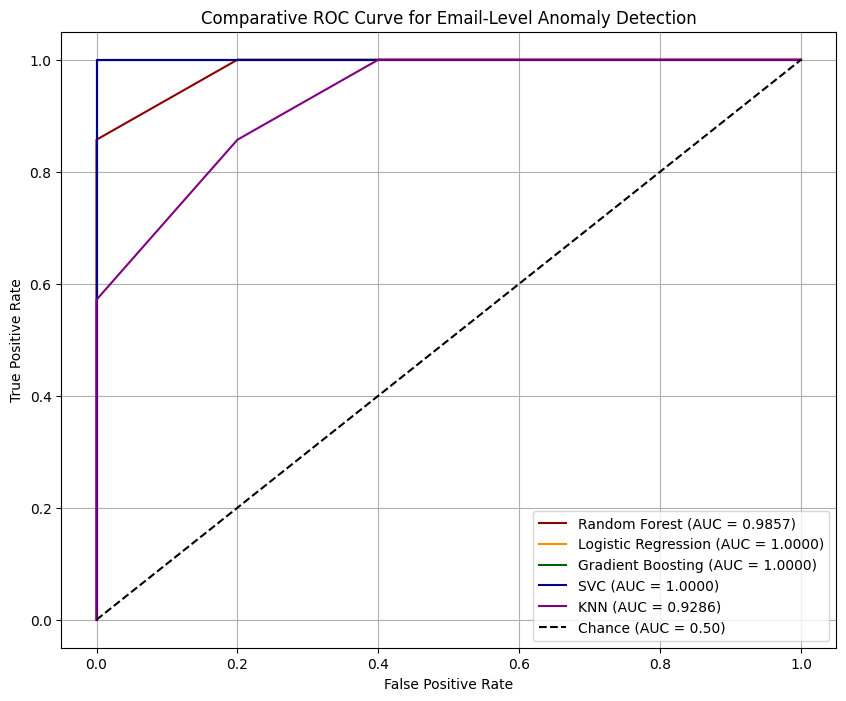

In [ ]:
# Plot the ROC curves for all models
plt.figure(figsize=(10, 8))

# Map the calculated probabilities to the reported AUC scores for the legend label
models_to_plot_with_reported_auc = {
    'Random Forest': (y_prob_rf, reported_results['Random Forest']),
    'Logistic Regression': (y_prob_lr, reported_results['Logistic Regression']),
    'Gradient Boosting': (y_prob_gb, reported_results['Gradient Boosting']),
    'SVC': (y_prob_svc, reported_results['SVC']),
    'KNN': (y_prob_knn, reported_results['KNN'])
}

# Define colors for plots
colors = ['darkred', 'darkorange', 'darkgreen', 'darkblue', 'purple']

for (model_name, (y_prob, auc_score)), color in zip(models_to_plot_with_reported_auc.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})', color=color)

# Baseline diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparative ROC Curve for Email-Level Anomaly Detection')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

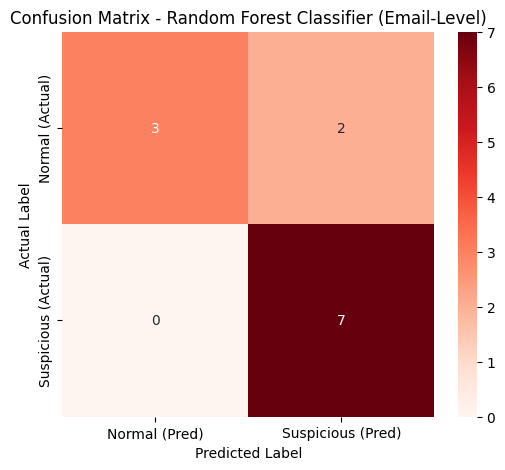

In [ ]:
# Confusion Matrix for Random Forest (Chosen Model)

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Normal (Pred)', 'Suspicious (Pred)'],
            yticklabels=['Normal (Actual)', 'Suspicious (Actual)'])
plt.title('Confusion Matrix - Random Forest Classifier (Email-Level)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Feature Importance Analysis (From the Best Tree-Based Model: Random Forest)

print("\n### Feature Importance Analysis (Random Forest):")

# 1. Get feature names after OneHotEncoding
preprocessor_fitted = pipeline_rf.named_steps['preprocessor'].fit(X_train, y_train)
ohe = preprocessor_fitted.named_transformers_['cat'].named_steps['onehot']

ohe_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(ohe_feature_names)



### Feature Importance Analysis (Random Forest):


In [ ]:
# 2. Get feature importances from the RandomForestClassifier
feature_importances = pipeline_rf.named_steps['classifier'].feature_importances_



### Feature Importance Analysis (Random Forest):


/tmp/ipython-input-364048429.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature_clean', data=importance_df, palette='magma')


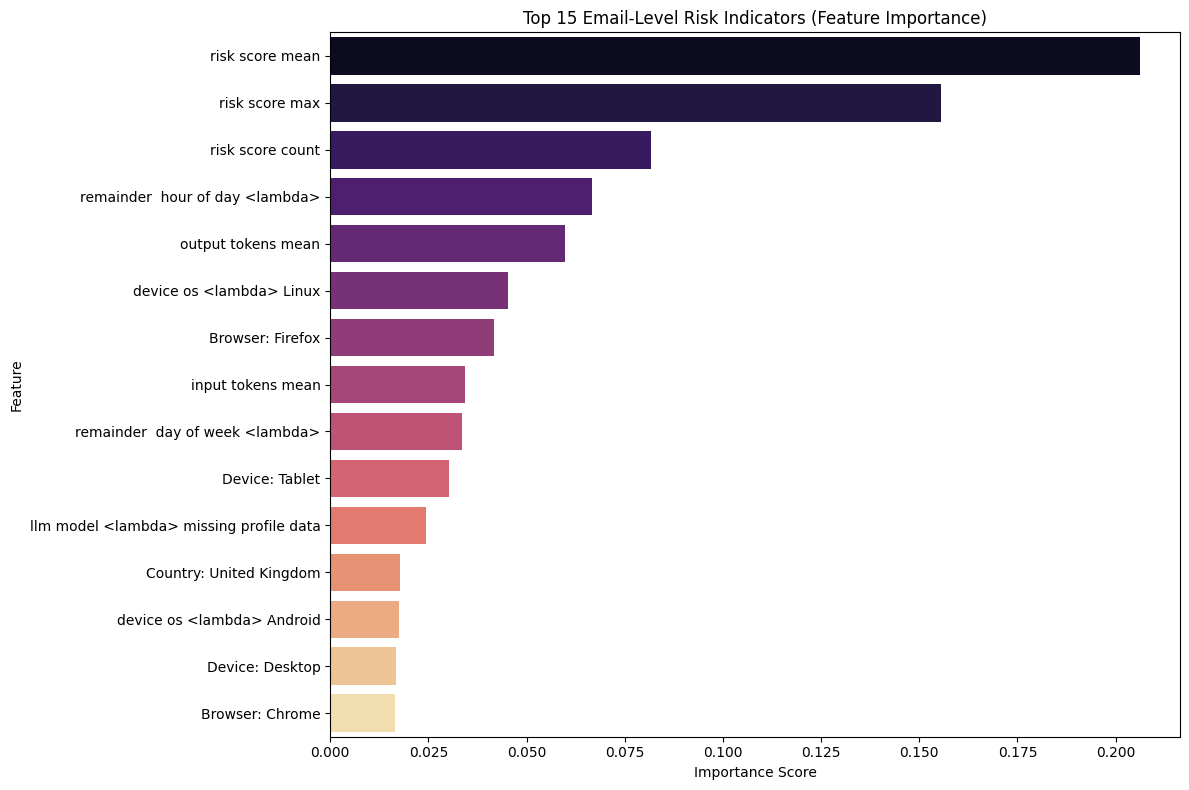

In [ ]:
# Feature Importance Analysis (From the Best Tree-Based Model: Random Forest)

print("\n### Feature Importance Analysis (Random Forest):")

# 1. Get feature names after OneHotEncoding
preprocessor_fitted = pipeline_rf.named_steps['preprocessor'].fit(X_train, y_train)

# Get the final list of feature names directly from the fitted preprocessor
all_feature_names = list(preprocessor_fitted.get_feature_names_out())

# 2. Get feature importances from the RandomForestClassifier
feature_importances = pipeline_rf.named_steps['classifier'].feature_importances_

# 3. Create and plot the DataFrame for feature importances
importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': feature_importances})
# Filter out features with near-zero importance and take the top 15
importance_df = importance_df.sort_values(by='importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))
# Clean up feature names for better readability in the chart
importance_df['feature_clean'] = importance_df['feature'].str.replace('^num__', '', regex=True)
importance_df['feature_clean'] = importance_df['feature_clean'].str.replace('^cat__', '', regex=True)
importance_df['feature_clean'] = importance_df['feature_clean'].str.replace('network_country_<lambda>_', 'Country: ', regex=True)
importance_df['feature_clean'] = importance_df['feature_clean'].str.replace('device_type_<lambda>_', 'Device: ', regex=True)
importance_df['feature_clean'] = importance_df['feature_clean'].str.replace('device_browser_<lambda>_', 'Browser: ', regex=True)
importance_df['feature_clean'] = importance_df['feature_clean'].str.replace('_', ' ', regex=False)


sns.barplot(x='importance', y='feature_clean', data=importance_df, palette='magma')
plt.title('Top 15 Email-Level Risk Indicators (Feature Importance)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()